# LightGBM: A Highly Efficient Gradient Boosting Decision Tree
This notebook will give you an example of how to train a LightGBM model to estimate click-through rates on an e-commerce advertisement. We will train a LightGBM based model on the Criteo dataset.

[LightGBM](https://github.com/Microsoft/LightGBM) is a gradient boosting framework that uses tree-based learning algorithms. It is designed to be distributed and efficient with the following advantages:
* Fast training speed and high efficiency.
* Low memory usage.
* Great accuracy.
* Support of parallel and GPU learning.
* Capable of handling large-scale data.

## Global Settings and Imports

In [1]:
import sys
sys.path.append('/home/shiv/Documents/DataScience/Kaggle/recommenders/')

In [2]:
import sys
import os
import numpy as np
import lightgbm as lgb
import papermill as pm
import scrapbook as sb
import pandas as pd
import pickle
import category_encoders as ce

from tempfile import TemporaryDirectory
from sklearn.metrics import mean_squared_error, mean_absolute_error

import recommenders.models.lightgbm.lightgbm_utils as lgb_utils
import recommenders.evaluation.python_evaluation as evaluator
from recommenders.utils import plot

print("System version: {}".format(sys.version))
print("LightGBM version: {}".format(lgb.__version__))

System version: 3.9.12 (main, Apr  5 2022, 06:56:58) 
[GCC 7.5.0]
LightGBM version: 3.3.2


In [3]:
from recommenders.utils.constants import (
    DEFAULT_USER_COL as USER_COL,
    DEFAULT_ITEM_COL as ITEM_COL,
    DEFAULT_RATING_COL as RATING_COL,
    DEFAULT_GENRE_COL as ITEM_FEAT_COL,
    DEFAULT_PREDICTION_COL as PREDICT_COL,
    DEFAULT_K,
    DEFAULT_THRESHOLD
)

### Parameter Setting
Let's set the main related parameters for LightGBM now. Basically, the task is regression (predicting rating of an item), so the objective function is set to loss and RMSE and MAE are used as metrics.

Generally, we can adjust the number of leaves (MAX_LEAF), the minimum number of data in each leaf (MIN_DATA), maximum number of trees (NUM_OF_TREES), the learning rate of trees (TREE_LEARNING_RATE) and EARLY_STOPPING_ROUNDS (to avoid overfitting) in the model to get better performance.

Besides, we can also adjust some other listed parameters to optimize the results. [In this link](https://github.com/Microsoft/LightGBM/blob/master/docs/Parameters.rst), a list of all the parameters is shown. Also, some advice on how to tune these parameters can be found [in this url](https://github.com/Microsoft/LightGBM/blob/master/docs/Parameters-Tuning.rst). 

In [4]:
MAX_LEAF = 64
MIN_DATA = 20
NUM_OF_TREES = 100
TREE_LEARNING_RATE = 0.15
EARLY_STOPPING_ROUNDS = 20
METRIC = ["rmse", "mae"]
# Generate negative samples for ndcg, hit
NUM_NEG_SAMPLES = 50
N_WORKERS = 5

In [5]:
# https://lightgbm.readthedocs.io/en/latest/Parameters.html
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'num_class': 1,
    'objective': "regression",
    'metric': METRIC,
    'num_leaves': MAX_LEAF,
    'min_data': MIN_DATA,
    'boost_from_average': True,
    # set it according to your cpu cores.
    'num_threads': 20,
    'feature_fraction': 0.8,
    'learning_rate': TREE_LEARNING_RATE,
    'num_iterations': 750
}

## Data Preparation

In [6]:
DATA_DIR = '/home/shiv/Documents/DataScience/Capstone/Data/'

In [7]:
all_data = pd.read_csv(DATA_DIR + 'wide_deep/Electronics/wide_deep_amzn_e_20.csv', 
                       header=None, low_memory=False)
all_data.columns = [USER_COL,ITEM_COL,RATING_COL,ITEM_FEAT_COL,
                    'unixTimeStamp','title','price','main_cat','category']
all_data.sort_values('unixTimeStamp', inplace=True)
all_data.reset_index(inplace=True, drop=True)

In [8]:
# Get the list of numerical and categorical columns
with open(DATA_DIR + 'xdeepfm/lst_genres.pkl', 'rb') as f:
    lst_genres = pickle.load(f)

cols = [USER_COL, ITEM_COL] # numerical column
for genre in lst_genres:
    cols.append(genre) # categorical columns

In [9]:
# We cannot use column names with spaces in lightGBM
cols_dict = {}
cate_cols = []
cols_dict[USER_COL] = USER_COL
cols_dict[ITEM_COL] = ITEM_COL
rev_cols_dict = {}
for idx, col in enumerate(cols[2:], start=1):
    cols_dict[col] = 'C' + str(idx)
    rev_cols_dict['C'+str(idx)] = col
    cate_cols.append('C' + str(idx))

### Split data into train, validation, and test

<b>Need to be done once.</b> [Jump to loading data](#read_csv) if you have already saved the data.

First, we cut three sets (train_data (first 80%), valid_data (middle 10%) and test_data (last 10%)), cut from the original all data. <br>
Notably, considering the reviews data is a kind of time-series streaming data, which is also very common in recommendation scenario, we split the data by its order.

In [ ]:
from recommenders.datasets.python_splitters import python_chrono_split
train, valid, test = python_chrono_split(all_data, [0.8,0.1,0.1], col_timestamp='unixTimeStamp')

In [ ]:
train = train[[RATING_COL,USER_COL,ITEM_COL,ITEM_FEAT_COL]].copy()
valid = valid[[RATING_COL,USER_COL,ITEM_COL,ITEM_FEAT_COL]].copy()
test  = test[[RATING_COL,USER_COL,ITEM_COL,ITEM_FEAT_COL]].copy()

## Expand genre into categorical columns

In [12]:
for col in cols[2:]:
    train[cols_dict[col]] = np.nan
    valid[cols_dict[col]] = np.nan
    test[cols_dict[col]] = np.nan

In [13]:
from tqdm import tqdm
tqdm.pandas()

def expand_genres(row):
    genres = row[ITEM_FEAT_COL].split('|')
    for genre in genres:
        row[cols_dict[genre]] = 1
    return row

train = train.progress_apply(expand_genres, axis=1)
valid = valid.progress_apply(expand_genres, axis=1)
test  = test.progress_apply(expand_genres, axis=1)

100%|███████████████████████████████████████████████████████████████████████████████████████| 530903/530903 [00:19<00:00, 26927.47it/s]


In [14]:
train.drop(columns=[ITEM_FEAT_COL], inplace=True)
valid.drop(columns=[ITEM_FEAT_COL], inplace=True)
test.drop(columns=[ITEM_FEAT_COL], inplace=True)

In [15]:
# 2 numeric features + 36 categorical features + label
all_data.shape, train.shape, valid.shape, test.shape

((5613183, 9), (4519730, 39), (562550, 39), (530903, 39))

In [17]:
train.to_csv(DATA_DIR + 'lightgbm/train_e.csv', header=False, index=False)
valid.to_csv(DATA_DIR + 'lightgbm/valid_e.csv', header=False, index=False)
test.to_csv(DATA_DIR + 'lightgbm/test_e.csv', header=False, index=False)

<a id='read_csv'></a>
### Read the saved train, valid, test data

In [10]:
train = pd.read_csv(DATA_DIR + 'lightgbm/train_e.csv', header=None)
train.columns = [RATING_COL, USER_COL, ITEM_COL] + cate_cols
valid = pd.read_csv(DATA_DIR + 'lightgbm/valid_e.csv', header=None)
valid.columns = [RATING_COL, USER_COL, ITEM_COL] + cate_cols
test  = pd.read_csv(DATA_DIR + 'lightgbm/test_e.csv', header=None)
test.columns = [RATING_COL, USER_COL, ITEM_COL] + cate_cols

## Basic Usage
### Ordinal Encoding
Considering LightGBM could handle the low-frequency features and missing value by itself, for basic usage, we only encode the string-like categorical features by an ordinal encoder.

In [11]:
ord_encoder = ce.ordinal.OrdinalEncoder(cols=cate_cols)
# print(ord_encoder.get_params())

def encode_csv(df, encoder, label_col, typ='fit'):
    if typ == 'fit':
        df = encoder.fit_transform(df)
    else:
        df = encoder.transform(df)
    y = df[label_col].values
    del df[label_col]
    return df, y

In [12]:
train_x, train_y = encode_csv(train, ord_encoder, RATING_COL)

In [13]:
#train_x, train_y = encode_csv(train_data, ord_encoder, label_col)
valid_x, valid_y = encode_csv(valid, ord_encoder, RATING_COL, 'transform')
test_x, test_y = encode_csv(test, ord_encoder, RATING_COL, 'transform')

print('Train Data Shape: X: {trn_x_shape}; Y: {trn_y_shape}.\nValid Data Shape: X: {vld_x_shape}; Y: {vld_y_shape}.\nTest Data Shape: X: {tst_x_shape}; Y: {tst_y_shape}.\n'
      .format(trn_x_shape=train_x.shape,
              trn_y_shape=train_y.shape,
              vld_x_shape=valid_x.shape,
              vld_y_shape=valid_y.shape,
              tst_x_shape=test_x.shape,
              tst_y_shape=test_y.shape,))
train_x.head()

Train Data Shape: X: (4519730, 38); Y: (4519730,).
Valid Data Shape: X: (562550, 38); Y: (562550,).
Test Data Shape: X: (530903, 38); Y: (530903,).



,userID,itemID,C1,C2,C3,C4,C5,C6,C7,C8,...,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36
0,0,19203,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,0,0,1,1,2,1,1,1,1,1,...,1,1,1,2,1,1,1,1,1,1
2,0,9662,1,2,2,1,1,2,1,1,...,1,1,1,1,1,1,1,1,1,1
3,0,9662,1,2,2,1,1,2,1,1,...,1,1,1,1,1,1,1,1,1,1
4,0,29877,1,1,2,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


### [Jump to Model Serving](#model_serving) if we already have a pre-built model!

### Create model
When both hyper-parameters and data are ready, we can create a model:

In [14]:
# https://lightgbm.readthedocs.io/en/v3.3.2/Python-API.html#training-api
    
lgb_train = lgb.Dataset(train_x, train_y.reshape(-1), params=params, categorical_feature=cate_cols)
lgb_valid = lgb.Dataset(valid_x, valid_y.reshape(-1), reference=lgb_train, categorical_feature=cate_cols)
lgb_test = lgb.Dataset(test_x, test_y.reshape(-1), reference=lgb_train, categorical_feature=cate_cols)
eval_result = {}

lgb_model = lgb.train(params,
                      lgb_train,
                      num_boost_round=NUM_OF_TREES,
                      early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                      evals_result= eval_result,
                      valid_sets=lgb_valid,
                      categorical_feature=cate_cols)

/home/shiv/anaconda3/envs/RecSys_39/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/shiv/anaconda3/envs/RecSys_39/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/shiv/anaconda3/envs/RecSys_39/lib/python3.9/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.140146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 606
[LightGBM] [Info] Number of data points in the train set: 4519730, number of used features: 38


/home/shiv/anaconda3/envs/RecSys_39/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/shiv/anaconda3/envs/RecSys_39/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] Start training from score 4.351199
[1]	valid_0's rmse: 1.15986	valid_0's l1: 0.887851
Training until validation scores don't improve for 20 rounds
[2]	valid_0's rmse: 1.15886	valid_0's l1: 0.886246
[3]	valid_0's rmse: 1.15814	valid_0's l1: 0.884963
[4]	valid_0's rmse: 1.15755	valid_0's l1: 0.883858
[5]	valid_0's rmse: 1.15719	valid_0's l1: 0.883011
[6]	valid_0's rmse: 1.15682	valid_0's l1: 0.882098
[7]	valid_0's rmse: 1.15652	valid_0's l1: 0.881315
[8]	valid_0's rmse: 1.15636	valid_0's l1: 0.880764
[9]	valid_0's rmse: 1.15622	valid_0's l1: 0.880328
[10]	valid_0's rmse: 1.1561	valid_0's l1: 0.880035
[11]	valid_0's rmse: 1.15597	valid_0's l1: 0.879673
[12]	valid_0's rmse: 1.15588	valid_0's l1: 0.879377
[13]	valid_0's rmse: 1.15582	valid_0's l1: 0.879108
[14]	valid_0's rmse: 1.15574	valid_0's l1: 0.878856
[15]	valid_0's rmse: 1.15564	valid_0's l1: 0.878531
[16]	valid_0's rmse: 1.15555	valid_0's l1: 0.878255
[17]	valid_0's rmse: 1.15544	valid_0's l1: 0.877939
[18]	valid_0

[159]	valid_0's rmse: 1.15239	valid_0's l1: 0.871405
[160]	valid_0's rmse: 1.15238	valid_0's l1: 0.871372
[161]	valid_0's rmse: 1.15237	valid_0's l1: 0.871355
[162]	valid_0's rmse: 1.15237	valid_0's l1: 0.871341
[163]	valid_0's rmse: 1.15236	valid_0's l1: 0.871331
[164]	valid_0's rmse: 1.15235	valid_0's l1: 0.871316
[165]	valid_0's rmse: 1.15234	valid_0's l1: 0.871312
[166]	valid_0's rmse: 1.15234	valid_0's l1: 0.871307
[167]	valid_0's rmse: 1.15234	valid_0's l1: 0.871307
[168]	valid_0's rmse: 1.15234	valid_0's l1: 0.871301
[169]	valid_0's rmse: 1.15233	valid_0's l1: 0.871304
[170]	valid_0's rmse: 1.15232	valid_0's l1: 0.871274
[171]	valid_0's rmse: 1.15232	valid_0's l1: 0.871266
[172]	valid_0's rmse: 1.15231	valid_0's l1: 0.871242
[173]	valid_0's rmse: 1.15232	valid_0's l1: 0.871242
[174]	valid_0's rmse: 1.15232	valid_0's l1: 0.871243
[175]	valid_0's rmse: 1.1523	valid_0's l1: 0.871225
[176]	valid_0's rmse: 1.15229	valid_0's l1: 0.871199
[177]	valid_0's rmse: 1.15229	valid_0's l1: 0.8

[316]	valid_0's rmse: 1.15165	valid_0's l1: 0.869636
[317]	valid_0's rmse: 1.15164	valid_0's l1: 0.869629
[318]	valid_0's rmse: 1.15164	valid_0's l1: 0.869629
[319]	valid_0's rmse: 1.15164	valid_0's l1: 0.869627
[320]	valid_0's rmse: 1.15164	valid_0's l1: 0.869625
[321]	valid_0's rmse: 1.15164	valid_0's l1: 0.869626
[322]	valid_0's rmse: 1.15163	valid_0's l1: 0.869618
[323]	valid_0's rmse: 1.15163	valid_0's l1: 0.869617
[324]	valid_0's rmse: 1.15163	valid_0's l1: 0.869614
[325]	valid_0's rmse: 1.15163	valid_0's l1: 0.869598
[326]	valid_0's rmse: 1.15163	valid_0's l1: 0.869587
[327]	valid_0's rmse: 1.15164	valid_0's l1: 0.869574
[328]	valid_0's rmse: 1.15163	valid_0's l1: 0.869554
[329]	valid_0's rmse: 1.15163	valid_0's l1: 0.869545
[330]	valid_0's rmse: 1.15163	valid_0's l1: 0.869543
[331]	valid_0's rmse: 1.15163	valid_0's l1: 0.869536
[332]	valid_0's rmse: 1.15162	valid_0's l1: 0.86951
[333]	valid_0's rmse: 1.15162	valid_0's l1: 0.869506
[334]	valid_0's rmse: 1.15162	valid_0's l1: 0.8

[473]	valid_0's rmse: 1.15126	valid_0's l1: 0.868606
[474]	valid_0's rmse: 1.15125	valid_0's l1: 0.868592
[475]	valid_0's rmse: 1.15125	valid_0's l1: 0.868586
[476]	valid_0's rmse: 1.15124	valid_0's l1: 0.868582
[477]	valid_0's rmse: 1.15124	valid_0's l1: 0.868574
[478]	valid_0's rmse: 1.15124	valid_0's l1: 0.868574
[479]	valid_0's rmse: 1.15124	valid_0's l1: 0.868573
[480]	valid_0's rmse: 1.15124	valid_0's l1: 0.868573
[481]	valid_0's rmse: 1.15124	valid_0's l1: 0.868574
[482]	valid_0's rmse: 1.15123	valid_0's l1: 0.868562
[483]	valid_0's rmse: 1.15123	valid_0's l1: 0.868551
[484]	valid_0's rmse: 1.15122	valid_0's l1: 0.868543
[485]	valid_0's rmse: 1.15122	valid_0's l1: 0.868542
[486]	valid_0's rmse: 1.15122	valid_0's l1: 0.868535
[487]	valid_0's rmse: 1.15122	valid_0's l1: 0.868535
[488]	valid_0's rmse: 1.15122	valid_0's l1: 0.868535
[489]	valid_0's rmse: 1.15121	valid_0's l1: 0.868517
[490]	valid_0's rmse: 1.15121	valid_0's l1: 0.868517
[491]	valid_0's rmse: 1.1512	valid_0's l1: 0.8

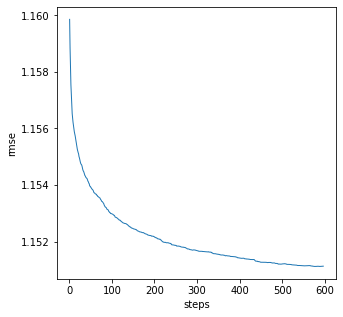

In [15]:
from recommenders.utils import plot
v = eval_result['valid_0']['rmse']
x = range(1, len(v)+1)
plot.line_graph(
    values=list(zip(v, x)),
    labels='rmse',
    x_name="steps",
    y_name='rmse',
#     subplot=(math.ceil(len(logs)/2), 2, i),
)

### Feature importance

In [16]:
feat_name, feat_imp = (lgb_model.feature_name(), lgb_model.feature_importance())
feat_imp, feat_name = zip(*sorted(zip(feat_imp, feat_name), reverse=True))

In [17]:
feat_name = [n if not n.startswith('C') else rev_cols_dict[n] for n in feat_name]
feat_name[:10], feat_imp[:10]

(['userID',
  'itemID',
  'All Electronics',
  'Cell Phones & Accessories',
  'Computers',
  'Home Audio & Theater',
  'Audio & Video Accessories',
  'Accessories',
  'Camera & Photo',
  'Computer Accessories & Peripherals'],
 (11379, 9974, 1412, 1167, 1115, 1011, 914, 905, 806, 637))

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

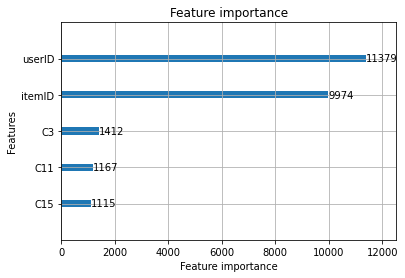

In [18]:
lgb.plot_importance(lgb_model, max_num_features=5)

Now let's see what is the model's performance:

In [19]:
test_preds = lgb_model.predict(test_x)

rmse = mean_squared_error(np.asarray(test_y.reshape(-1)), np.asarray(test_preds))
mae = mean_absolute_error(np.asarray(test_y.reshape(-1)), np.asarray(test_preds))
res_basic = {"rmse": rmse, "mae": mae}
print(res_basic)

{'rmse': 1.453011282813894, 'mae': 0.9014153288417129}


### Save the model

In [20]:
MODEL_DIR = '/home/shiv/Documents/DataScience/Capstone/Modeling/lightGBM/model/'
save_file = os.path.join(MODEL_DIR, r'finished.model')
lgb_model.save_model(save_file)

<a id="model_serving"></a>
### Model Serving

In [21]:
MODEL_DIR = '/home/shiv/Documents/DataScience/Capstone/Modeling/lightGBM/model/'
save_file = os.path.join(MODEL_DIR, r'finished.model')

loaded_model = lgb.Booster(model_file=save_file)

#### Rating metrics (rmse, mae) on test set

In [22]:
# eval the performance again
test_preds = lgb_model.predict(test_x)

rmse = mean_squared_error(np.asarray(test_y.reshape(-1)), np.asarray(test_preds))
mae = mean_absolute_error(np.asarray(test_y.reshape(-1)), np.asarray(test_preds))
res_basic = {"rmse": rmse, "mae": mae}
print(res_basic) # Note that the results match from earlier cell

{'rmse': 1.453011282813894, 'mae': 0.9014153288417129}


### Prepare for ranking metrics for users from the test file

<b>Only need to run once</b>
([Jump to calculating ndcg](#calc_metrics))

In [39]:
from multiprocessing import Process, Queue
import random

RANDOM_SEED = 42

TST_DATA_DIR = '/home/shiv/Documents/DataScience/Capstone/Data/lightgbm'

In [40]:
train_grp = train[[USER_COL,ITEM_COL]].groupby(USER_COL).agg(list)
items_df = train.drop_duplicates([ITEM_COL]).copy()
items_df.drop(columns=[USER_COL, RATING_COL], inplace=True)
items_df.set_index(ITEM_COL, inplace=True)

In [53]:
processors = []
items_set = set(train[ITEM_COL].unique())

def sample_function(train_grp, test, items_df, cate_cols, i, num_workers, seed, data_dir):
    nrows = test.shape[0]
    each = nrows // num_workers
    start = i*each
    end = nrows if i == num_workers - 1 else (i+1)*each
    sym = ['!','@','#','$','%']

    # print(i, start, end, test.iloc[start:end].shape)
    random.seed(seed)
    tst_w_neg_samples_path = data_dir + f'lightgbm/amzn_e_tst_w_neg{i}.txt'
    
    user_col = []
    item_col = []
    rating_col = []
    feat_cols = []
    for c in cate_cols:
        feat_cols.append([])
    
    for j, row in test.iloc[start:end].iterrows():
        u = row[USER_COL]
        positive_item = row[ITEM_COL]
        tmp_df = train_grp.loc[u]
        assert(tmp_df.shape[0] != 0)
        
        items_seen_set = set(tmp_df[ITEM_COL])
        items_not_seen = list(items_set - items_seen_set)
        user_col.append(int(u))
        item_col.append(int(positive_item))
        rating_col.append(row[RATING_COL])
        for k, c in enumerate(cate_cols):
            feat_cols[k].append(float(row[c]))

        cnt = 0
        neg_items = set()
        while cnt < NUM_NEG_SAMPLES:
            neg_item = random.choice(items_not_seen)
            if neg_item == positive_item or neg_item in neg_items:
                continue

            cnt += 1
            tmp_df = items_df.loc[neg_item]
            assert(tmp_df.shape[0] != 0)
            
            user_col.append(int(u))
            item_col.append(int(neg_item))
            rating_col.append(5.0) # unused
            for k, c in enumerate(cate_cols):
                feat_cols[k].append(float(tmp_df[c]))
        if j % 10_000 == 0:
            print(sym[i], end='')
            
    test_dict = {USER_COL: user_col, ITEM_COL: item_col, RATING_COL: rating_col}
    for k, c in enumerate(cate_cols):
        test_dict[c] = feat_cols[k]
    X_test = pd.DataFrame(test_dict)
    X_test.to_csv(tst_w_neg_samples_path, header=False, index=False)

for i in range(N_WORKERS):
    processors.append(
        Process(
            target = sample_function,
            args = (train_grp, test, items_df, cate_cols, i, N_WORKERS, RANDOM_SEED, DATA_DIR)
        ))
    # processors[-1].daemon = True
    processors[-1].start()

for i in range(N_WORKERS):
    processors[i].join()

!$@%#!$@%#!$@%#!$@%#!$@%#!$@%#!$@%#!$@%#!$@%#!$@%#!$@%

<a id="calc_metrics"></a>
# Ranking metrics (ndcg@k, hit@k)

In [26]:
NUM_NEG_SAMPLES = 50
N_WORKERS = 5

group_preds = []
group = NUM_NEG_SAMPLES + 1

for i in range(N_WORKERS):
    tst_w_neg_samples_path = DATA_DIR + f'lightgbm/amzn_e_tst_w_neg{i}.txt'
    X_test = pd.read_csv(tst_w_neg_samples_path, header=None)
    X_test.columns=[USER_COL,ITEM_COL,RATING_COL] + cate_cols
    X_test.drop(columns=[RATING_COL], inplace=True)
    print('Read', f'amzn_e_tst_w_neg{i}.txt')

    print('Predicting...', X_test.shape[0])
    # Rating prediction
    step_pred = lgb_model.predict(X_test)
    group_preds.extend(np.reshape(step_pred, (-1, group)))
    
    del X_test

Read amzn_e_tst_w_neg0.txt
Predicting... 5415180
Read amzn_e_tst_w_neg1.txt
Predicting... 5415180
Read amzn_e_tst_w_neg2.txt
Predicting... 5415180
Read amzn_e_tst_w_neg3.txt
Predicting... 5415180
Read amzn_e_tst_w_neg4.txt
Predicting... 5415333


In [27]:
NDCG = 0.0
HT = 0.0
for each_preds in group_preds:
    predictions = np.array(each_preds)
    predictions = -1.0 * predictions

    # print(predictions)
    # print(predictions.argsort())    
    rank = predictions.argsort().argsort()[0]
    if rank < 10:
        NDCG += 1 / np.log2(rank + 2)
        HT += 1
NDCG/len(group_preds),HT/len(group_preds)

(0.0724577113002917, 0.1631578649960539)

### Top K for a user across all products

In [33]:
ratings_df = pd.read_csv(DATA_DIR + 'wide_deep/Electronics/wide_deep_amzn_e_20.csv',
                         header=None, low_memory=False)
ratings_df.columns=['userID','itemID', 'rating','genre','unixTimeStamp','title','price','main_cat', 'category']
ratings_df = ratings_df[[USER_COL, ITEM_COL, ITEM_FEAT_COL, 'title']]

users = ratings_df.drop_duplicates(USER_COL)[[USER_COL]].reset_index(drop=True)
print("# users", users.shape[0])

items = ratings_df.drop_duplicates(ITEM_COL)
print("# items", items.shape[0])

user = 8009

all_items_set = set()
rev_item_lookup = {} # dictionary for reverse lookup of title and genre
for _, row in items.iterrows():
    i = row[ITEM_COL]
    rev_item_lookup[i] = {'title': row['title'], 'genre': row[ITEM_FEAT_COL]}
    all_items_set.add(i)
    

tmp_df = train[train[USER_COL]==user]
items_rated_set = set(tmp_df[ITEM_COL].values)

# Ignore items already seen (makes sense for movies but Amazon products???
items_not_seen = all_items_set - items_rated_set
lst_items_not_seen = list(items_not_seen)

items_df = train.drop_duplicates([ITEM_COL]).copy()
items_df.drop(columns=[USER_COL, RATING_COL], inplace=True)
items_df.set_index(ITEM_COL, inplace=True) # for fast lookup

# users 830668
# items 63725


In [34]:
it_cnt = 0
user_col = []
item_col = []
feat_cols = []
for c in cate_cols:
    feat_cols.append([])

for it in lst_items_not_seen:

    tmp_df = items_df.loc[it]
    assert(tmp_df.shape[0] != 0)
    
    user_col.append(int(user))
    item_col.append(int(it))
    for k, c in enumerate(cate_cols):
        feat_cols[k].append(float(tmp_df[c]))
    it_cnt += 1
    if it_cnt % 1000 == 0:
        print('*', end='')
        
test_dict = {USER_COL: user_col, ITEM_COL: item_col}
for k, c in enumerate(cate_cols):
    test_dict[c] = feat_cols[k]

***************************************************************

In [35]:
X_test = pd.DataFrame(test_dict)

print('Predicting...', X_test.shape[0])
# Rating prediction
step_pred = lgb_model.predict(X_test)

Predicting... 63478


In [36]:
X_test['prediction'] = step_pred
X_test['title'] = X_test[ITEM_COL].map(lambda x: rev_item_lookup[x]['title'])
X_test[ITEM_FEAT_COL] = X_test[ITEM_COL].map(lambda x: rev_item_lookup[x][ITEM_FEAT_COL])
X_test.drop(columns = [USER_COL, ITEM_COL] + cate_cols, inplace=True)
X_test.sort_values('prediction', ascending=False, inplace=True)
X_test.reset_index(inplace=True, drop=True)
X_test.to_csv(DATA_DIR + f'lightgbm/output_{user}.csv', index=False) # header = True
X_test.head(10)

,prediction,title,genre
0,5.316779,Amazon Kindle 2 (2nd Generation) USB Car Charg...,Amazon Devices|Cell Phones & Accessories|Acces...
1,5.294511,Zeikos ZE-SG26R 3 Pieces Ultra Clear Deluxe Sc...,Camera & Photo|Cell Phones & Accessories|Acces...
2,5.285888,ANSMANN Individual cell battery charger Energy...,Home Audio & Theater|Cell Phones & Accessories...
3,5.276212,"CAVN 2-Pack Compatible Fitbit Surge Charger, R...",Cell Phones & Accessories|Sports & Outdoors|Sp...
4,5.276212,Getwow 10-Pack Silicon Fastener Ring for Fitbi...,Cell Phones & Accessories|Sports & Outdoors|Sp...
5,5.276212,"[Upgrade] Bike Phone Mount, Tryone Bike Mount ...",Cell Phones & Accessories|Sports & Outdoors|Sp...
6,5.276212,HanTop Apple Watch Band 38mm Stainless Steel A...,Cell Phones & Accessories|Sports & Outdoors|Sp...
7,5.276212,bayite Accessory Silicone Watch Band for Fitbi...,Cell Phones & Accessories|Sports & Outdoors|Sp...
8,5.276212,"TUSITA Fitbit One Charging Cable, Replacement ...",Cell Phones & Accessories|Sports & Outdoors|Sp...
9,5.276212,"Garmin vívokeeper Wrist Band, 9-Pack",Cell Phones & Accessories|Sports & Outdoors|Sp...


<script type="text/javascript" src="http://cdn.mathjax.org/mathjax/latest/MathJax.js?config=default"></script>
## Optimized Usage
### Label-encoding and Binary-encoding
Next, since LightGBM has a better capability in handling dense numerical features effectively, we try to convert all the categorical features in original data into numerical ones, by label-encoding [3] and binary-encoding [4].<br>
Also due to the sequence property of review dataset, the label-encoding we adopted is executed one-by-one, which means we encode the samples in order, by the information of the previous samples before each sample (sequential label-encoding and sequential count-encoding). Besides, we also filter the low-frequency categorical features and fill the missing values by the mean of corresponding columns for the numerical features. (consulting `lgb_utils.NumEncoder`)

Specifically, in `lgb_utils.NumEncoder`, the main steps are as follows.
* <s>Firstly, we convert the low-frequency categorical features to `"LESS"` and the missing categorical features to `"UNK"`.</s>
* <s>Secondly, we convert the missing numerical features into the mean of corresponding columns.</s>
* Thirdly, the string-like categorical features are ordinal encoded like the example shown in basic usage. 
* And then, we target encode the categorical features in the samples order one-by-one. For each sample, we add the label and count information of its former samples into the data and produce new features. Formally, for $i=1,2,...,n$, we add $\frac{\sum\nolimits_{j=1}^{i-1} I(x_j=c) \cdot y}{\sum\nolimits_{j=1}^{i-1} I(x_j=c)}$ as a new label feature for current sample $x_i$, where $c$ is a category to encode in current sample, so $(i-1)$ is the number of former samples, and $I(\cdot)$ is the indicator function that check the former samples contain $c$ (whether $x_j=c$) or not. At the meantime, we also add the count frequency of $c$, which is $\frac{\sum\nolimits_{j=1}^{i-1} I(x_j=c)}{i-1}$, as a new count feature. 
* Finally, based on the results of ordinal encoding, we add the binary encoding results as new columns into the data.<BR>

<B>Note that the statistics used in the above process only updates when fitting the training set</B>, while maintaining static when transforming the testing set because the label of test data should be considered as unknown.

In [37]:
nume_cols = [USER_COL, ITEM_COL]
label_col = RATING_COL

In [40]:
# for item in cate_cols:
#     value_counts = train[item].value_counts()
#     print(item, value_counts)

## The string-like categorical features are ordinal encoded as shown in basic usage.

## Dynamic target encoding

* And then, we target encode the categorical features in the samples order one-by-one. For each sample, we add the label and count information of its former samples into the data and produce new features. Formally, for $i=1,2,...,n$, we add $\frac{\sum\nolimits_{j=1}^{i-1} I(x_j=c) \cdot y}{\sum\nolimits_{j=1}^{i-1} I(x_j=c)}$ as a new label feature for current sample $x_i$, where $c$ is a category to encode in current sample, so $(i-1)$ is the number of former samples, and $I(\cdot)$ is the indicator function that check the former samples contain $c$ (whether $x_j=c$) or not.<br>
At the same time, we also add the count frequency of $c$, which is $\frac{\sum\nolimits_{j=1}^{i-1} I(x_j=c)}{i-1}$, as a new count feature.

In [34]:
def unpackbits(x, num_bits):
    """Convert a decimal value numpy.ndarray into multi-binary value numpy.ndarray ([1,2]->[[1,0],[0,1]])
    """
    xshape = list(x.shape) # 1D array, xshape = rows
    x = x.reshape([-1, 1]) # 2D array, rowsx1
    to_and = 2 ** np.arange(num_bits).reshape([1, num_bits]) # [[1, 2, 4, 8]]
    # print(xshape + [num_bits]) # [rows, 4]
    return (x & to_and).astype(bool).astype(int).reshape(xshape + [num_bits])

unpackbits(np.array([1,2,3]), 4) # example of one hot encoding

array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [1, 1, 0, 0]])

In [46]:
import gc
from tqdm import tqdm
import collections

class NumEncoder(object):
    """Encode all the categorical features into numerical ones by 
    sequential label encoding, sequential count encoding, and binary encoding. 
    Additionally, it also filters the low-frequency categories and fills the missing values.
    """

    def __init__(self, cate_cols, nume_cols, label_col, threshold=10, thresrate=0.99):
        """Constructor.

        Args:
            cate_cols (list): The columns of categorical features.
            nume_cols (list): The columns of numerical features.
            label_col (object): The column of Label.
            threshold (int): The categories whose frequency is lower than the threshold will be 
                filtered (be treated as "<LESS>").
            thresrate (float): The (1.0 - thersrate, default 1%) lowest-frequency categories will 
                also be filtered.
        """
        self.label_name = label_col
        self.cate_cols = cate_cols
        self.dtype_dict = {}
        for item in cate_cols:
            self.dtype_dict[item] = "str"
        for item in nume_cols:
            self.dtype_dict[item] = "float"
        self.nume_cols = nume_cols
        self.tgt_nume_cols = []
        self.encoder = ce.ordinal.OrdinalEncoder(cols=cate_cols)
        self.threshold = threshold
        self.thresrate = thresrate

        self.save_cate_avgs = {}
        self.save_value_filter = {}
        self.save_num_embs = {}
        self.Max_len = {}
        self.samples = 0

    def fit_transform(self, df):
        df = df.astype(dtype=self.dtype_dict)
        self.samples = df.shape[0]
#         print("Filtering and fillna features", self.samples, df.shape)
#         for item in tqdm(self.cate_cols):
#             value_counts = df[item].value_counts()
            
#             print(item)
#             print(value_counts.shape)
#             num = value_counts.shape[0]
            
#             self.save_value_filter[item] = list(
#                 value_counts[: int(num * self.thresrate)][value_counts > self.threshold].index
#             )
            
#             rm_values = set(value_counts.index) - set(self.save_value_filter[item])
#             df[item] = df[item].map(lambda x: "<LESS>" if x in rm_values else x)
#             df[item] = df[item].fillna("<UNK>")
            
#             del value_counts
#             gc.collect()

#         for item in tqdm(self.nume_cols):
#             df[item] = df[item].fillna(df[item].mean())
#             self.save_num_embs[item] = {"sum": df[item].sum(), "cnt": df[item].shape[0]}

        print("Ordinal encoding cate features")
        # ordinal_encoding
        df = self.encoder.fit_transform(df)

        print("Target encoding cate features")
        # dynamic_targeting_encoding
        for item in tqdm(self.cate_cols):
            feats = df[item].values
            labels = df[self.label_name].values
            feat_encoding = {"mean": [], "count": []}
            self.save_cate_avgs[item] = collections.defaultdict(lambda: [0, 0])
            for idx in range(self.samples):
                cur_feat = feats[idx]
                if cur_feat in self.save_cate_avgs[item]:
                    feat_encoding["mean"].append(
                        self.save_cate_avgs[item][cur_feat][0]
                        / self.save_cate_avgs[item][cur_feat][1]
                    )
                    feat_encoding["count"].append(
                        self.save_cate_avgs[item][cur_feat][1] / idx
                    )
                else:
                    feat_encoding["mean"].append(0)
                    feat_encoding["count"].append(0)
                self.save_cate_avgs[item][cur_feat][0] += labels[idx]
                self.save_cate_avgs[item][cur_feat][1] += 1
            df[item + "_t_mean"] = feat_encoding["mean"]
            df[item + "_t_count"] = feat_encoding["count"]
            self.tgt_nume_cols.append(item + "_t_mean")
            self.tgt_nume_cols.append(item + "_t_count")

        print("Start manual binary encoding")
        rows = None
        for item in tqdm(self.nume_cols + self.tgt_nume_cols):
            feats = df[item].values
            if rows is None:
                rows = feats.reshape((-1, 1))
            else:
                rows = np.concatenate([rows, feats.reshape((-1, 1))], axis=1)
            del feats
            gc.collect()
        for item in tqdm(self.cate_cols):
            feats = df[item].values
            Max = df[item].max()
            bit_len = len(bin(Max)) - 2
            samples = self.samples
            self.Max_len[item] = bit_len
            res = unpackbits(feats, bit_len).reshape((samples, -1))
            rows = np.concatenate([rows, res], axis=1)
            del feats
            gc.collect()
        trn_y = np.array(df[self.label_name].values).reshape((-1, 1))
        del df
        gc.collect()
        trn_x = np.array(rows)
        return trn_x, trn_y

    # for test dataset
    def transform(self, df):
        """Input a testing / validation set (pandas.DataFrame) and return the converted 2 numpy.ndarray (x,y).

        Args:
            df (pandas.DataFrame): Input dataframe

        Returns:
            numpy.ndarray, numpy.ndarray: New features and labels.
        """
        df = df.astype(dtype=self.dtype_dict)
        samples = df.shape[0]
#         print("Filtering and fillna features")
#         for item in tqdm(self.cate_cols):
#             value_counts = df[item].value_counts()
#             rm_values = set(value_counts.index) - set(self.save_value_filter[item])
#             df[item] = df[item].map(lambda x: "<LESS>" if x in rm_values else x)
#             df[item] = df[item].fillna("<UNK>")

#         for item in tqdm(self.nume_cols):
#             mean = self.save_num_embs[item]["sum"] / self.save_num_embs[item]["cnt"]
#             df[item] = df[item].fillna(mean)

        print("Ordinal encoding cate features")
        # ordinal_encoding
        df = self.encoder.transform(df)

        print("Target encoding cate features")
        # dynamic_targeting_encoding
        for item in tqdm(self.cate_cols):
            avgs = self.save_cate_avgs[item]
            df[item + "_t_mean"] = df[item].map(
                lambda x: avgs[x][0] / avgs[x][1] if x in avgs else 0
            )
            df[item + "_t_count"] = df[item].map(
                lambda x: avgs[x][1] / self.samples if x in avgs else 0
            )

        print("Start manual binary encoding")
        rows = None
        for item in tqdm(self.nume_cols + self.tgt_nume_cols):
            feats = df[item].values
            if rows is None:
                rows = feats.reshape((-1, 1))
            else:
                rows = np.concatenate([rows, feats.reshape((-1, 1))], axis=1)
            del feats
            gc.collect()
        for item in tqdm(self.cate_cols):
            feats = df[item].values
            bit_len = self.Max_len[item]
            res = unpackbits(feats, bit_len).reshape((samples, -1))
            rows = np.concatenate([rows, res], axis=1)
            del feats
            gc.collect()
        vld_y = np.array(df[self.label_name].values).reshape((-1, 1))
        del df
        gc.collect()
        vld_x = np.array(rows)
        return vld_x, vld_y


In [47]:
num_encoder = NumEncoder(cate_cols, nume_cols, label_col)

train_x, train_y = num_encoder.fit_transform(train)
valid_x, valid_y = num_encoder.transform(valid)
test_x, test_y = num_encoder.transform(test)
del num_encoder

print('Train Data Shape: X: {trn_x_shape}; Y: {trn_y_shape}.\nValid Data Shape: X: {vld_x_shape}; Y: {vld_y_shape}.\nTest Data Shape: X: {tst_x_shape}; Y: {tst_y_shape}.\n'
      .format(trn_x_shape=train_x.shape,
              trn_y_shape=train_y.shape,
              vld_x_shape=valid_x.shape,
              vld_y_shape=valid_y.shape,
              tst_x_shape=test_x.shape,
              tst_y_shape=test_y.shape,))


Ordinal encoding cate features
Target encoding cate features


 86%|████████████████████████████████████████████████████████████████████████████████████▍             | 31/36 [01:36<00:15,  3.09s/it]/tmp/ipykernel_3889143/2399632350.py:95: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[item + "_t_count"] = feat_encoding["count"]
 89%|███████████████████████████████████████████████████████████████████████████████████████           | 32/36 [01:39<00:12,  3.11s/it]/tmp/ipykernel_3889143/2399632350.py:94: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[item + "_t_mean"] = feat_encoding["mean"

Start manual binary encoding


  0%|                                                                                                           | 0/36 [00:00<?, ?it/s]


NameError: name 'unpackbits' is not defined

### Training and Evaluation

In [49]:
lgb_train = lgb.Dataset(train_x, train_y.reshape(-1), params=params)
lgb_valid = lgb.Dataset(valid_x, valid_y.reshape(-1), reference=lgb_train)
eval_result = {}
lgb_model = lgb.train(params,
                      lgb_train,
                      num_boost_round=NUM_OF_TREES*5,
                      early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                      evals_result= eval_result,
                      valid_sets=lgb_valid)

/home/shiv/anaconda3/envs/RecSys_39/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/shiv/anaconda3/envs/RecSys_39/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/shiv/anaconda3/envs/RecSys_39/lib/python3.9/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.186191 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 618
[LightGBM] [Info] Number of data points in the train set: 4519730, number of used features: 38
[LightGBM] [Info] Start training from score 4.351199
[1]	valid_0's rmse: 1.15986	valid_0's l1: 0.887851
Training until validation scores don't improve for 20 rounds
[2]	valid_0's rmse: 1.15886	valid_0's l1: 0.886246
[3]	valid_0's rmse: 1.15814	valid_0's l1: 0.884963
[4]	valid_0's rmse: 1.15755	valid_0's l1: 0.883858
[5]	valid_0's rmse: 1.15719	valid_0's l1: 0.883011
[6]	valid_0's rmse: 1.15682	valid_0's l1: 0.882098
[7]	valid_0's rmse: 1.15652	valid_0's l1: 0.881315
[8]	valid_0's rmse: 1.15636	valid_0's l1: 0.880764
[9]	valid_0's rmse: 1.15622	valid_0's l1: 0.880328
[10]	valid_0's rmse: 1.1561	valid_0's l1: 0.880035
[11]	valid_0's rmse

[153]	valid_0's rmse: 1.15244	valid_0's l1: 0.87152
[154]	valid_0's rmse: 1.15244	valid_0's l1: 0.871504
[155]	valid_0's rmse: 1.15243	valid_0's l1: 0.8715
[156]	valid_0's rmse: 1.15242	valid_0's l1: 0.871477
[157]	valid_0's rmse: 1.15242	valid_0's l1: 0.871465
[158]	valid_0's rmse: 1.15242	valid_0's l1: 0.871465
[159]	valid_0's rmse: 1.15239	valid_0's l1: 0.871405
[160]	valid_0's rmse: 1.15238	valid_0's l1: 0.871372
[161]	valid_0's rmse: 1.15237	valid_0's l1: 0.871355
[162]	valid_0's rmse: 1.15237	valid_0's l1: 0.871341
[163]	valid_0's rmse: 1.15236	valid_0's l1: 0.871331
[164]	valid_0's rmse: 1.15235	valid_0's l1: 0.871316
[165]	valid_0's rmse: 1.15234	valid_0's l1: 0.871312
[166]	valid_0's rmse: 1.15234	valid_0's l1: 0.871307
[167]	valid_0's rmse: 1.15234	valid_0's l1: 0.871307
[168]	valid_0's rmse: 1.15234	valid_0's l1: 0.871301
[169]	valid_0's rmse: 1.15233	valid_0's l1: 0.871304
[170]	valid_0's rmse: 1.15232	valid_0's l1: 0.871274
[171]	valid_0's rmse: 1.15232	valid_0's l1: 0.871

[313]	valid_0's rmse: 1.15165	valid_0's l1: 0.869644
[314]	valid_0's rmse: 1.15165	valid_0's l1: 0.869642
[315]	valid_0's rmse: 1.15165	valid_0's l1: 0.869643
[316]	valid_0's rmse: 1.15165	valid_0's l1: 0.869636
[317]	valid_0's rmse: 1.15164	valid_0's l1: 0.869629
[318]	valid_0's rmse: 1.15164	valid_0's l1: 0.869629
[319]	valid_0's rmse: 1.15164	valid_0's l1: 0.869627
[320]	valid_0's rmse: 1.15164	valid_0's l1: 0.869625
[321]	valid_0's rmse: 1.15164	valid_0's l1: 0.869626
[322]	valid_0's rmse: 1.15163	valid_0's l1: 0.869618
[323]	valid_0's rmse: 1.15163	valid_0's l1: 0.869617
[324]	valid_0's rmse: 1.15163	valid_0's l1: 0.869614
[325]	valid_0's rmse: 1.15163	valid_0's l1: 0.869598
[326]	valid_0's rmse: 1.15163	valid_0's l1: 0.869587
[327]	valid_0's rmse: 1.15164	valid_0's l1: 0.869574
[328]	valid_0's rmse: 1.15163	valid_0's l1: 0.869554
[329]	valid_0's rmse: 1.15163	valid_0's l1: 0.869545
[330]	valid_0's rmse: 1.15163	valid_0's l1: 0.869543
[331]	valid_0's rmse: 1.15163	valid_0's l1: 0.

[470]	valid_0's rmse: 1.15126	valid_0's l1: 0.868609
[471]	valid_0's rmse: 1.15126	valid_0's l1: 0.868607
[472]	valid_0's rmse: 1.15126	valid_0's l1: 0.868608
[473]	valid_0's rmse: 1.15126	valid_0's l1: 0.868606
[474]	valid_0's rmse: 1.15125	valid_0's l1: 0.868592
[475]	valid_0's rmse: 1.15125	valid_0's l1: 0.868586
[476]	valid_0's rmse: 1.15124	valid_0's l1: 0.868582
[477]	valid_0's rmse: 1.15124	valid_0's l1: 0.868574
[478]	valid_0's rmse: 1.15124	valid_0's l1: 0.868574
[479]	valid_0's rmse: 1.15124	valid_0's l1: 0.868573
[480]	valid_0's rmse: 1.15124	valid_0's l1: 0.868573
[481]	valid_0's rmse: 1.15124	valid_0's l1: 0.868574
[482]	valid_0's rmse: 1.15123	valid_0's l1: 0.868562
[483]	valid_0's rmse: 1.15123	valid_0's l1: 0.868551
[484]	valid_0's rmse: 1.15122	valid_0's l1: 0.868543
[485]	valid_0's rmse: 1.15122	valid_0's l1: 0.868542
[486]	valid_0's rmse: 1.15122	valid_0's l1: 0.868535
[487]	valid_0's rmse: 1.15122	valid_0's l1: 0.868535
[488]	valid_0's rmse: 1.15122	valid_0's l1: 0.

In [50]:
test_preds = lgb_model.predict(test_x)
rmse = mean_squared_error(np.asarray(test_y.reshape(-1)), np.asarray(test_preds))
mae = mean_absolute_error(np.asarray(test_y.reshape(-1)), np.asarray(test_preds))
res_basic = {"rmse": rmse, "mae": mae}
print(res_basic)

{'rmse': 1.453011282813894, 'mae': 0.9014153288417129}


## Model saving and loading
Now we finish the basic training and testing for LightGBM, next let's try to save and reload the model, and then evaluate it again.

In [51]:
with TemporaryDirectory() as tmp:
    save_file = os.path.join(tmp, r'finished.model')
    lgb_model.save_model(save_file)
    loaded_model = lgb.Booster(model_file=save_file)

# eval the performance again
test_preds = lgb_model.predict(test_x)

rmse = mean_squared_error(np.asarray(test_y.reshape(-1)), np.asarray(test_preds))
mae = mean_absolute_error(np.asarray(test_y.reshape(-1)), np.asarray(test_preds))
res_basic = {"rmse": rmse, "mae": mae}
print(res_basic)

{'rmse': 1.453011282813894, 'mae': 0.9014153288417129}


## Additional Reading

\[1\] Guolin Ke, Qi Meng, Thomas Finley, Taifeng Wang, Wei Chen, Weidong Ma, Qiwei Ye, and Tie-Yan Liu. 2017. LightGBM: A highly efficient gradient boosting decision tree. In Advances in Neural Information Processing Systems. 3146–3154.<br>
\[2\] The parameters of LightGBM: https://github.com/Microsoft/LightGBM/blob/master/docs/Parameters.rst <br>
\[3\] Anna Veronika Dorogush, Vasily Ershov, and Andrey Gulin. 2018. CatBoost: gradient boosting with categorical features support. arXiv preprint arXiv:1810.11363 (2018).<br>
\[4\] Scikit-learn. 2018. categorical_encoding. https://github.com/scikit-learn-contrib/categorical-encoding<br>
